In [2]:
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import string
import numpy as np
from PIL import Image
from torchvision.transforms import v2
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import CustomClass
from func_file import train_model, test_model, collate_fn

데이터 출처<hr>
- https://www.kaggle.com/datasets/backalla/words-mnist
- https://tc11.cvc.uab.es/datasets/
- https://www.kaggle.com/datasets/hnthnt/jp-font-image-dataset-02?select=00000083.jpg
- https://www.kaggle.com/datasets/ngkinwang/iam-dataset
- https://www.kaggle.com/datasets/ravi02516/20-ocr-dataset
- https://www.kaggle.com/datasets/frlemarchand/synthetic-kmnist-pages?select=synthetic_kmnist_pages.csv

In [3]:
random.seed(56)

In [4]:
train_data_path = './data/archive (3)/new_test/new_train'
test_data_path = './data/archive (3)/new_test/new_test'

In [5]:
transformer = v2.Compose(transforms=
                                 [transforms.ToTensor(),
                                  v2.Resize(size=[64,128])
                                  ])

In [6]:
train_name_list = random.sample(os.listdir(train_data_path), 15000)
test_name_list = os.listdir(test_data_path)

In [7]:
train_img_list = []
test_img_list = []
train_label = []
test_label = []

In [8]:
for img_name in train_name_list:
    img = Image.open(train_data_path+'/'+img_name)
    train_img_list.append(transformer(img).numpy())
    train_label.append(img_name.split('.jpg')[0])
    img.close()

for img_name in test_name_list:
    img = Image.open(test_data_path+'/'+img_name)
    test_img_list.append(transformer(img).numpy())
    test_label.append(img_name.split('.jpg')[0])
    img.close()

In [9]:
# train_img_list[0]

In [10]:
trainTS = torch.tensor(train_img_list)
testTS = torch.tensor(test_img_list)

C:\Users\낙지들의왕\AppData\Local\Temp\ipykernel_21032\3395511533.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  trainTS = torch.tensor(train_img_list)


In [11]:
trainTS.shape, testTS.shape

(torch.Size([15000, 3, 64, 128]), torch.Size([1472, 3, 64, 128]))

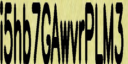

In [12]:
tf = transforms.ToPILImage()
sample = tf(trainTS[12])
sample

In [13]:
eng_only_vocab = CustomClass.Vocab()
eng_only_vocab.resetCode()

In [14]:
trainDS = CustomClass.CustomDataset(trainTS, np.array(train_label), eng_only_vocab)
testDS1 = CustomClass.CustomDataset(testTS, np.array(test_label), eng_only_vocab)

In [15]:
check_id = 1200
trainDS[check_id][1], train_label[check_id], len(trainDS[check_id][1]), len(test_label[check_id])

(array([15, 55, 41, 58, 62, 39]), '.vhyCf', 6, 15)

In [16]:
torch.random.manual_seed(100)
gen = torch.Generator().manual_seed(100)

In [17]:
trainDS1, validDS1 = random_split(trainDS, [0.9, 0.1], generator=gen)

In [18]:
torch.cuda.is_available()

True

In [19]:
# for d in trainDS1:
#     print(d[1].shape)

In [20]:
# trainDS1[0], trainDS1[0][0].shape, trainDS1[0][1].shape

In [21]:
BATCH_SIZE = 100
trainDL1 = DataLoader(trainDS1, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
validDL1 = DataLoader(validDS1, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
testDL1 = DataLoader(testDS1, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)

In [21]:
# len(trainDL1)

In [22]:
# for f, t in trainDL1:
#     print(f.shape, t.shape)
#     print(f.dtype, t.dtype)
#     print(f)
#     print(t)
#     break

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CustomClass.CustomModel(3, len(eng_only_vocab)).to(device)
optim = torch.optim.Adam(model.parameters())
schd = torch.optim.lr_scheduler.ReduceLROnPlateau(optim)

In [24]:
model

CustomModel(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(

In [25]:
result = train_model(model, optim, trainDL1, validDL1, device, epochs=100, schd=schd)

Proceeding.......
Epoch [    1 /   100] ------
train cost = 2.201967239379883, valid cost = 2.8946197032928467
Proceeding.......
Epoch [    2 /   100] ------
train cost = 2.3458361625671387, valid cost = 2.930649995803833
Proceeding.......
Epoch [    3 /   100] ------
train cost = 2.3774499893188477, valid cost = 3.291215181350708
Proceeding.......
Epoch [    4 /   100] ------
train cost = 2.148334503173828, valid cost = 3.4341955184936523
Proceeding.......
Epoch [    5 /   100] ------
train cost = 2.173970937728882, valid cost = 3.566409111022949
Proceeding.......
Epoch [    6 /   100] ------
train cost = 2.1361818313598633, valid cost = 3.4190711975097656
Proceeding.......
Epoch [    7 /   100] ------
train cost = 2.1727001667022705, valid cost = 3.3331267833709717
Proceeding.......
Epoch [    8 /   100] ------
train cost = 2.282094717025757, valid cost = 3.1073009967803955
Proceeding.......
Epoch [    9 /   100] ------
train cost = 2.261525869369507, valid cost = 3.512648344039917
P

In [26]:
torch.save(model, './bbbest_model100.pkl')

In [23]:
testModel1 = torch.load('./bbbest_model100.pkl')
# testModel2 = torch.load('./best_model100.pkl')

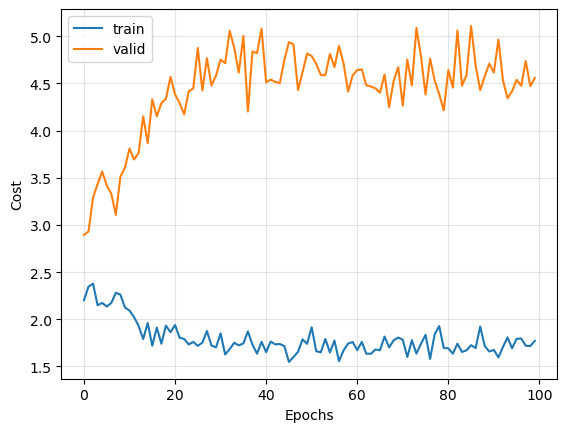

In [28]:
train_costs = [res.cpu().item() for res in result[0]]
valid_costs = [res.cpu().item() for res in result[1]]

plt.plot(train_costs)
plt.plot(valid_costs)
plt.legend(['train', 'valid'])
plt.grid(alpha=0.35)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

In [24]:
test_result = test_model(testModel1, testDL1, device)

Proceeding....Trial   0 --- 
test cost = 1.8979369401931763
Trial   1 --- 
test cost = 1.780903697013855
Trial   2 --- 
test cost = 1.815851092338562
Trial   3 --- 
test cost = 1.6600489616394043
Trial   4 --- 
test cost = 1.881367564201355
Trial   5 --- 
test cost = 1.9053268432617188
Trial   6 --- 
test cost = 1.789797067642212
Trial   7 --- 
test cost = 1.7509846687316895
Trial   8 --- 
test cost = 1.996107578277588
Trial   9 --- 
test cost = 1.8222216367721558
.Trial  10 --- 
test cost = 1.784554123878479
Trial  11 --- 
test cost = 1.7992520332336426
Trial  12 --- 
test cost = 1.7049660682678223
Trial  13 --- 
test cost = 1.6949349641799927


In [25]:
sum(test_result) / len(test_result)

1.806018088545118

In [ ]:
# check_id = 2000
# 
# imgTS = torch.FloatTensor(test_img_list[check_id]).unsqueeze(dim=0).to(device)
# 
# testModel1.eval()
# 
# pre1 = testModel1(imgTS)
# 
# print(torch.argmax(pre1, dim=-1)[0])
# 
# for id in torch.argmax(pre1, dim=-1)[0]:
#     letter = eng_only_vocab.decoder[id.item()]
#     if letter != '<PAD>':
#         print(letter, end=', ')
#     
# print(f'\n{test_label[check_id]}')
# print(tf(trainTS[check_id]).show())